In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srustamovaa","key":"1ca8fcfaba504eec8d63918c446b69c8"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d dansbecker/food-101

100% 9.38G/9.38G [03:41<00:00, 40.1MB/s]
100% 9.38G/9.38G [03:41<00:00, 45.4MB/s]


In [ ]:
import os
if not(os.path.isdir('./data')): os.mkdir('./data')
!unzip  /content/food-101.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/food-101/food-101/images/tacos/1030289.jpg  
  inflating: /content/data/food-101/food-101/images/tacos/1033196.jpg  
  inflating: /content/data/food-101/food-101/images/tacos/1036030.jpg  
  inflating: /content/data/food-101/food-101/images/tacos/1042175.jpg  
  inflating: /content/data/food-101/food-101/images/tacos/1044043.jpg  
  inflating: /content/data/food-101/food-101/images/tacos/1058697.jpg  
  inflating: /content/data/food-101/food-101/images/tacos/1059239.jpg  
  inflating: /content/data/food-101/food-101/images/tacos/1059326.jpg  
  inflating: /content/data/food-101/food-101/images/tacos/1066762.jpg  
  inflating: /content/data/food-101/food-101/images/tacos/1070967.jpg  
  inflating: /content/data/food-101/food-101/images/tacos/1073468.jpg  
  inflating: /content/data/food-101/food-101/images/tacos/1075296.jpg  
  inflating: /content/data/food-101/food-101/images/tacos/1085243.jpg  
  inflating: 

In [ ]:
os.listdir('/content/data/food-101/food-101/meta')

['labels.txt',
 'train.json',
 'test.json',
 'train.txt',
 'test.txt',
 'classes.txt']

In [ ]:
!head /content/data/food-101/food-101/meta/test.txt

apple_pie/1011328
apple_pie/101251
apple_pie/1034399
apple_pie/103801
apple_pie/1038694
apple_pie/1047447
apple_pie/1068632
apple_pie/110043
apple_pie/1106961
apple_pie/1113017


In [ ]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

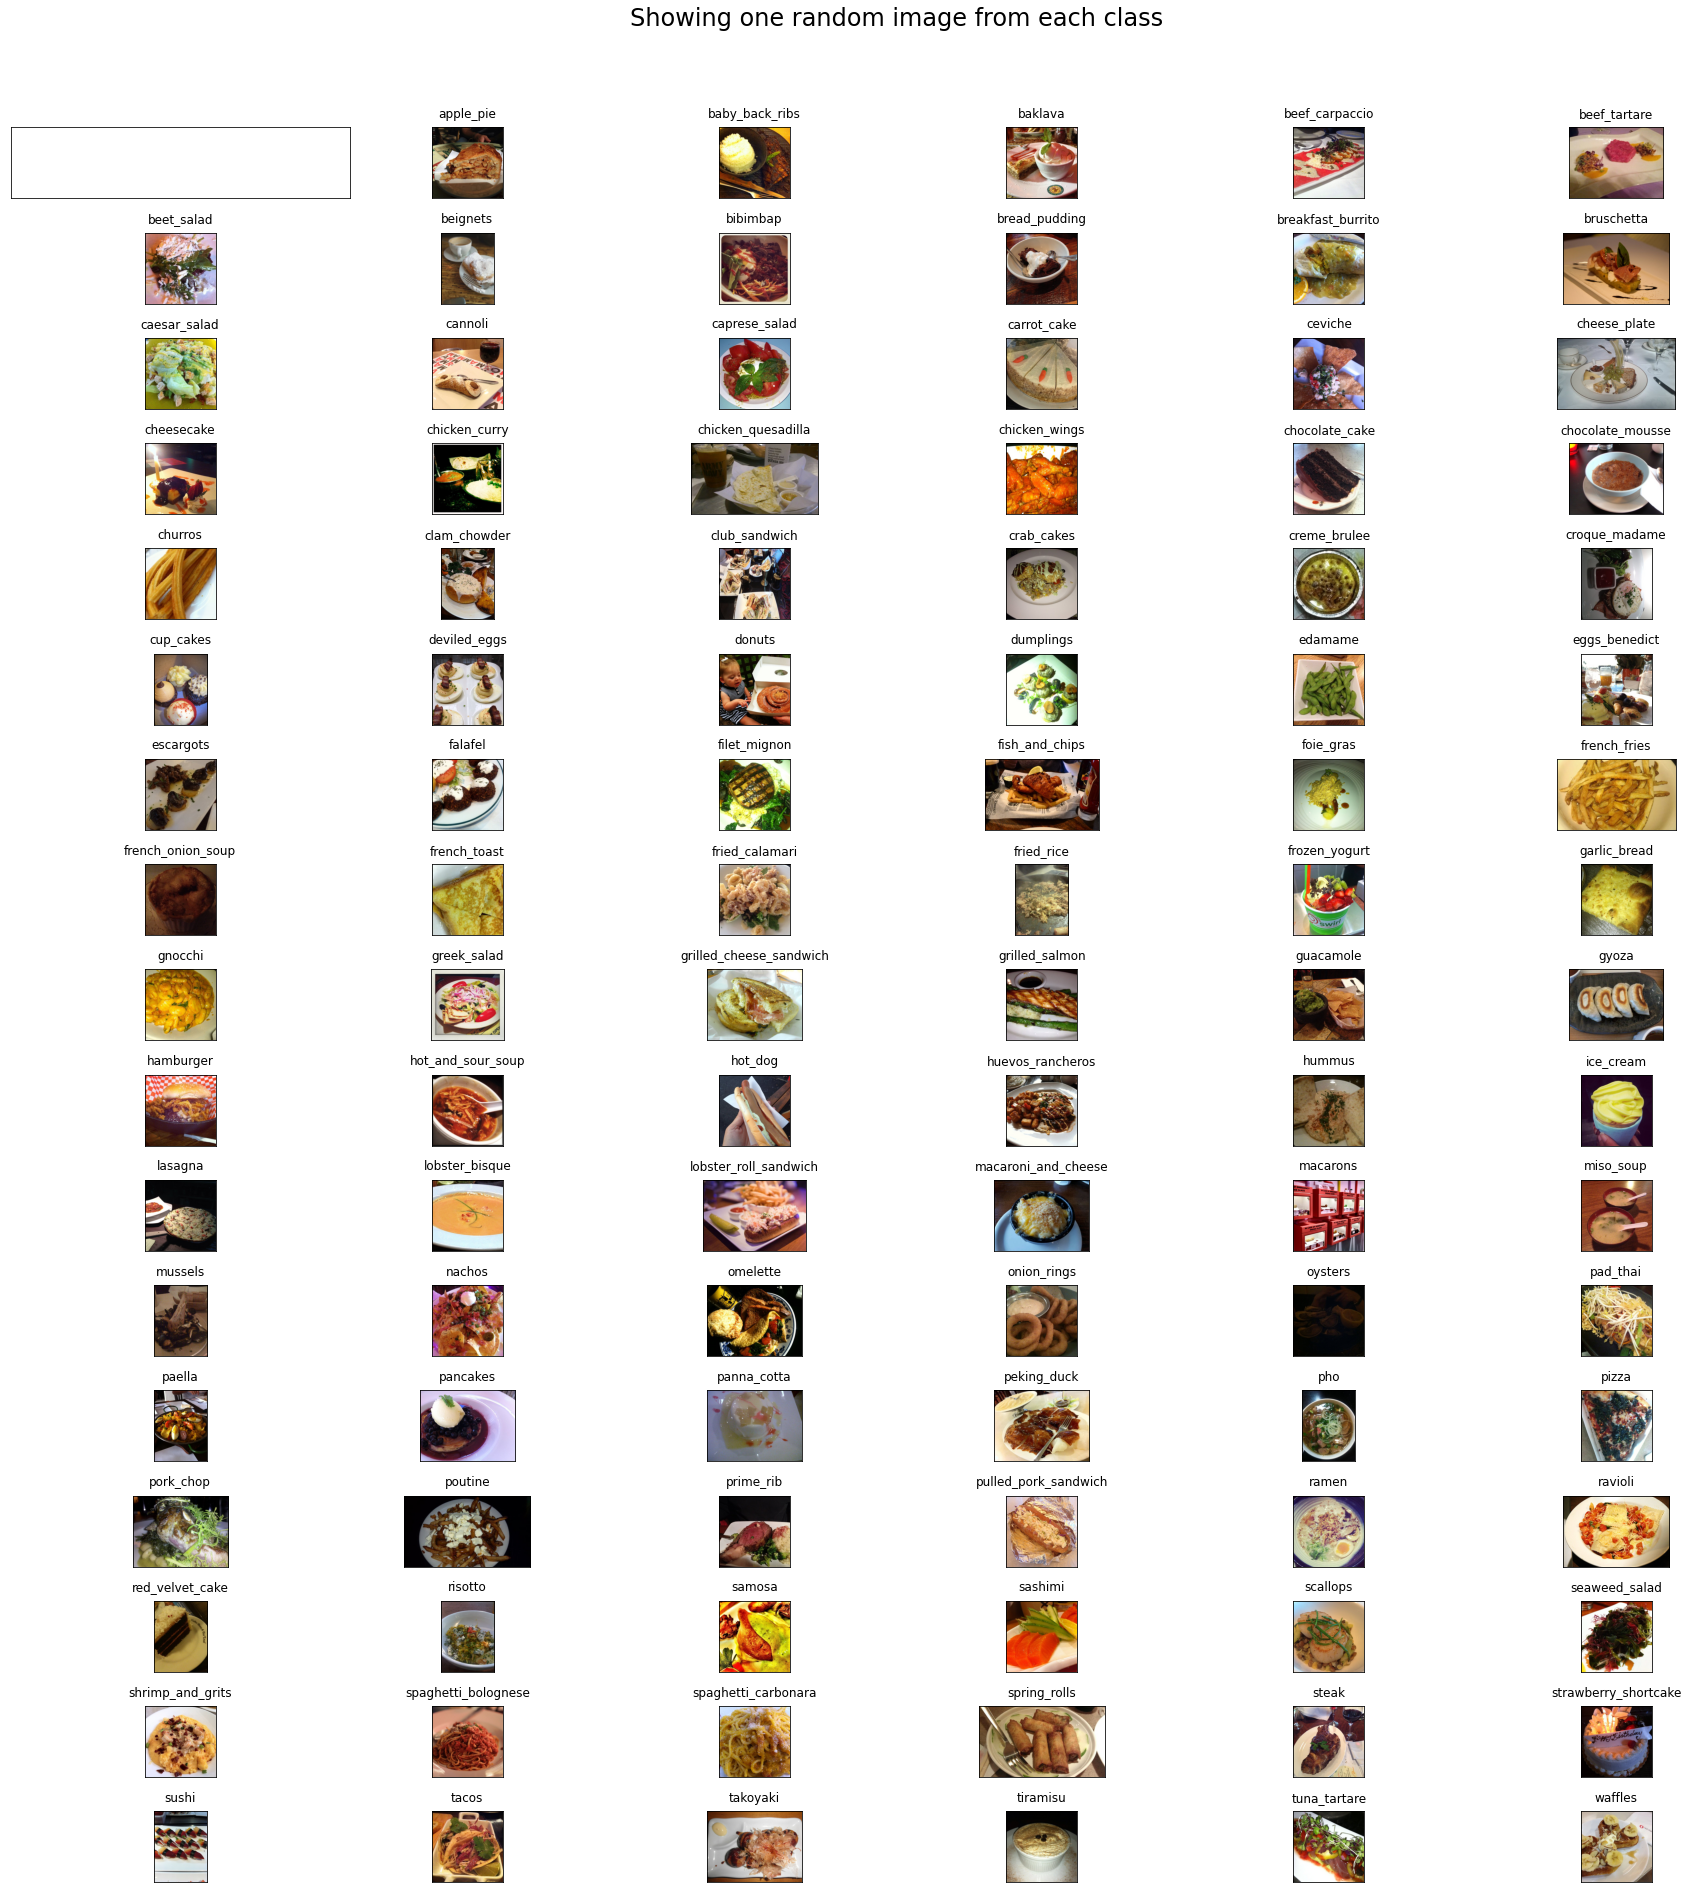

In [ ]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "/content/data/food-101/food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

In [ ]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
%cd /
print("Creating train data...")
prepare_data('/content/data/food-101/food-101/meta/train.txt', '/content/data/food-101/food-101/images/', 'train')

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('/content/data/food-101/food-101/meta/test.txt', '/content/data/food-101/food-101/images/', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [ ]:
del foods_sorted[0] # remove .DS_Store from the list

In [ ]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
def pick_n_random_classes(n):
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  return food_list

In [ ]:
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [ ]:
food_list = pick_n_random_classes(101)
print("These are the randomly picked food classes we will be training the model on...\n", food_list)

These are the randomly picked food classes we will be training the model on...
 ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobste

In [ ]:
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [ ]:
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

Creating training data folder with new classes...
Copying images into apple_pie
Copying images into baby_back_ribs
Copying images into baklava
Copying images into beef_carpaccio
Copying images into beef_tartare
Copying images into beet_salad
Copying images into beignets
Copying images into bibimbap
Copying images into bread_pudding
Copying images into breakfast_burrito
Copying images into bruschetta
Copying images into caesar_salad
Copying images into cannoli
Copying images into caprese_salad
Copying images into carrot_cake
Copying images into ceviche
Copying images into cheese_plate
Copying images into cheesecake
Copying images into chicken_curry
Copying images into chicken_quesadilla
Copying images into chicken_wings
Copying images into chocolate_cake
Copying images into chocolate_mousse
Copying images into churros
Copying images into clam_chowder
Copying images into club_sandwich
Copying images into crab_cakes
Copying images into creme_brulee
Copying images into croque_madame
Copyin

In [ ]:
print("Total number of samples in train folder")
!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into baby_back_ribs
Copying images into baklava
Copying images into beef_carpaccio
Copying images into beef_tartare
Copying images into beet_salad
Copying images into beignets
Copying images into bibimbap
Copying images into bread_pudding
Copying images into breakfast_burrito
Copying images into bruschetta
Copying images into caesar_salad
Copying images into cannoli
Copying images into caprese_salad
Copying images into carrot_cake
Copying images into ceviche
Copying images into cheese_plate
Copying images into cheesecake
Copying images into chicken_curry
Copying images into chicken_quesadilla
Copying images into chicken_wings
Copying images into chocolate_cake
Copying images into chocolate_mousse
Copying images into churros
Copying images into clam_chowder
Copying images into club_sandwich
Copying images into crab_cakes
Copying images into creme_brulee
Copying images into croque_madame
Copying image

In [ ]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [ ]:
n= 101

In [ ]:
K.clear_session()

n_classes = n
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 75750 #75750
nb_validation_samples = 25250 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_20class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_20class.log')

history_11class = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=20,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_20class.hdf5')

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
Epoch 1/20
4734/4734 [==============================] - ETA: 0s - loss: 4.7642 - accuracy: 0.0978
Epoch 00001: val_loss improved from inf to 3.71641, saving model to best_model_20class.hdf5
4734/4734 [==============================] - 2260s 477ms/step - loss: 4.7642 - accuracy: 0.0978 - val_loss: 3.7164 - val_accuracy: 0.3500
Epoch 2/20
4734/4734 [==============================] - ETA: 0s - loss: 3.4916 - accuracy: 0.3307
Epoch 00002: val_loss improved from 3.71641 to 2.39259, saving model to best_model_20class.hdf5
4734/4734 [==============================] - 2149s 454ms/step - loss: 3.4916 - accuracy: 0.3307 - val_loss: 2.3926 - val_accuracy: 0.5630
Epoch 3/20
4734/4734 [==============================] - ETA: 0s - loss: 2.7442 - accuracy: 0.4644
Epoch 00003: val_loss improved from 2.39259 to 1.88503, saving model to best_model_20class.hdf5
4734/4734 [==============================] - 2040s 431ms

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history_11class,'FOOD101-Inceptionv3')
plot_loss(history_11class,'FOOD101-Inceptionv3')

In [ ]:
K.clear_session()
model_best = load_model('model_trained_20class.hdf5',compile = False)

In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# Downloading images from internet using the URLs
!wget -O omelette.jpg https://media-cdn.tripadvisor.com/media/photo-s/01/b8/f1/55/tuna-omelette.jpg
!wget -O pizza.jpg https://fastly.4sqi.net/img/general/600x600/71293277_jIPxqVYWcUt9mXpdG7MH1VYiNLDck5GWTQoYXeeSN8I.jpg
!wget -O caesar.jpg https://i.pinimg.com/originals/52/4f/f9/524ff94cef1d12911344ec6c74183f0c.jpg
!wget -O cake.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Fries_2.jpg/1200px-Fries_2.jpg
# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files

# from google.colab import files
# image = files.upload()

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('cake.jpg')
images.append('pizza.jpg')
images.append('omelette.jpg')
images.append("caesar.jpg")
predict_class(model_best, images, True)